# a1901457_Shahana Ganesh Kumar

# Optimizing Convolutional Neural Networks for Image Classification

In [ ]:
# saving and loading Python objects
import pickle
# Provides functions to interact with the operating system like file and directory handling
import os
# For reading and extracting `.tar` files
import tarfile
# To split data into training and testing sets
from sklearn.model_selection import train_test_split
# visualizations
import matplotlib.pyplot as plt
from PIL import Image
# mathematical functions
import numpy as np
# count the frequency of elements in a collection (e.g., classes in a dataset)
from collections import Counter
# PyTorch library
import torch
# For data augmentation and preprocessing (e.g resizing, normalizing images)
import torchvision.transforms as transforms
# To create custom datasets and batch loaders for training/testing
from torch.utils.data import Dataset, DataLoader
# Provides neural network modules and layers for model building
import torch.nn as nn
# Includes optimization algorithms like SGD, Adam for model training
import torch.optim as optim
# Contains pre-trained deep learning models for transfer learning
from torchvision import models
# To create Cartesian product of iterables, useful in grid searches for hyperparameters
from itertools import product
# Ignore all warnings
# Suppresses all warnings, useful to avoid unnecessary output during model training
import warnings
warnings.filterwarnings("ignore")




In [3]:

def load_cifar10_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        X = data_dict[b'data']
        Y = data_dict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_cifar10_data(data_dir):
    X_train = []
    Y_train = []
    for i in range(1, 6):
        X, Y = load_cifar10_batch(os.path.join(data_dir, 'data_batch_' + str(i)))
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    
    X_test, Y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

    return X_train, Y_train, X_test, Y_test

In [4]:
def extract_tar_file(file_path, extract_to='.'):
    if file_path.endswith("tar.gz"):
        with tarfile.open(file_path) as tar:
            tar.extractall(path=extract_to)
            print(f"Extracted {file_path} to {extract_to}")

# Extracting CIFAR-10 dataset
cifar10_path = 'cifar-10-python.tar.gz'
data_dir = 'cifar-10-batches-py'  

extract_tar_file(cifar10_path, extract_to='.')
X_train, Y_train, X_test, Y_test = load_cifar10_data(data_dir)

# Split training data into training and validation sets (80% train, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Print the shapes to verify the split
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {Y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {Y_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {Y_test.shape}")


Extracted cifar-10-python.tar.gz to .
Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000,)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


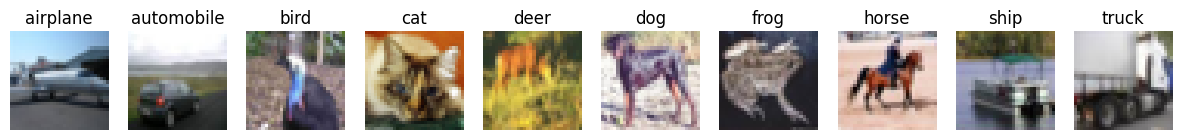

In [5]:
# CIFAR-10 label names
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck']

# creating plots for each labels
def plot_images_for_each_label(X, Y, labels, num_classes=10):
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 15))
    printed_labels = set()

    # Loop through the dataset
    for i in range(len(Y)):
        label = Y[i] 
        if label not in printed_labels:  
            axes[label].imshow(X[i].astype('uint8'))
            # Setting title as label name
            axes[label].set_title(labels[label])  
            axes[label].axis('off') 
            printed_labels.add(label)
        # Stop condition if all labels are printed
        if len(printed_labels) == num_classes: 
            break

plot_images_for_each_label(X_train, Y_train, cifar10_labels)
plt.show()


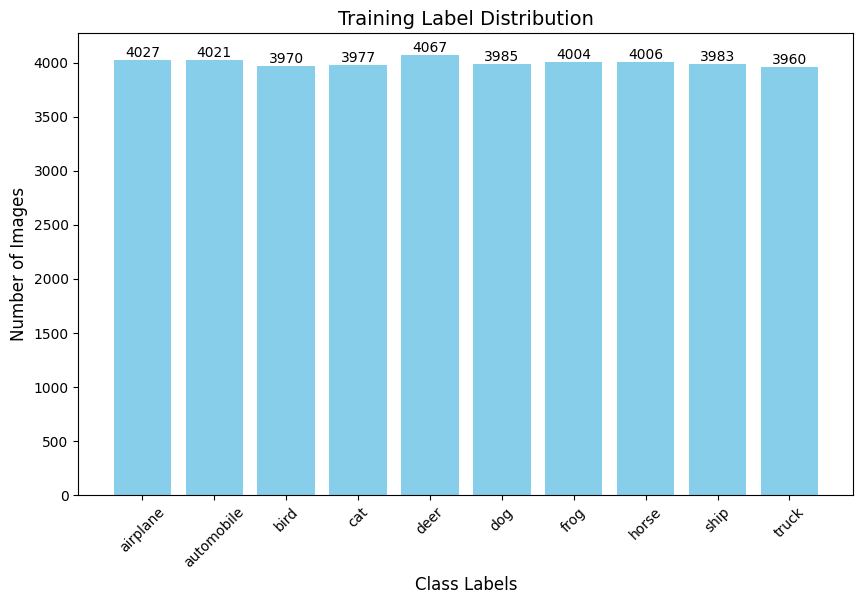

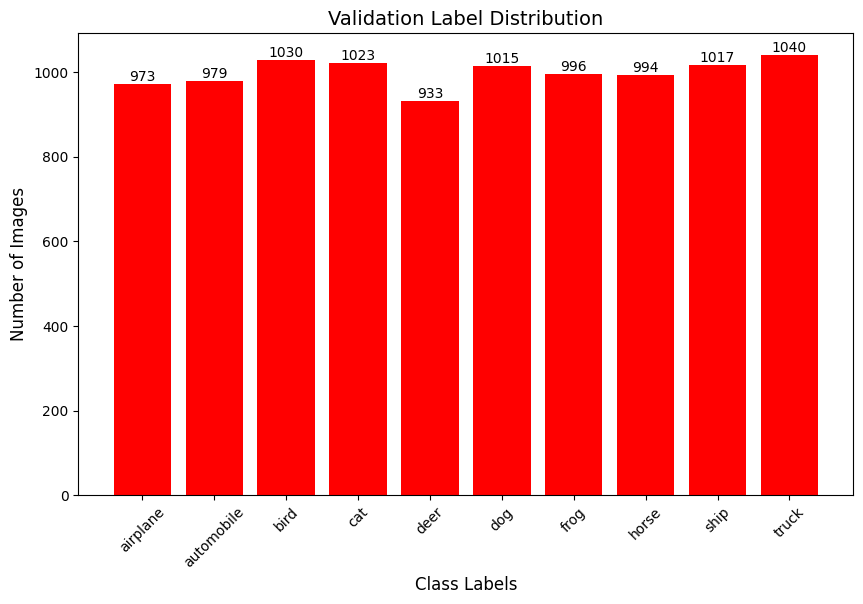

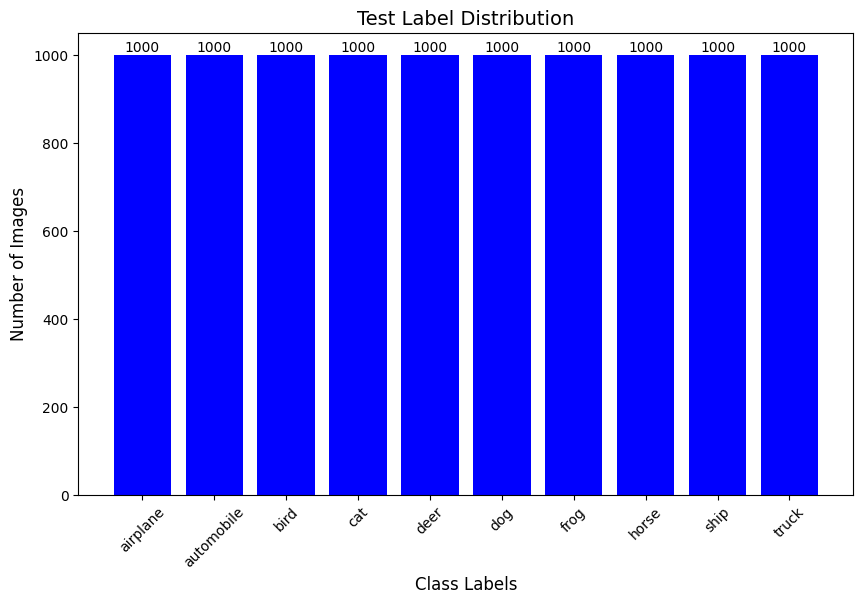

In [6]:
def plot_label_distribution(Y_data, title, color):
    unique_labels, counts = np.unique(Y_data, return_counts=True)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(cifar10_labels, counts, color=color)

    # titles and labels
    plt.title(f'{title} Label Distribution', fontsize=14)
    plt.xlabel('Class Labels', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    
    # Display count values on top of each bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', 
                 ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45)
    plt.show()

# Plot distribution for training set
plot_label_distribution(Y_train, "Training", "skyblue")

# Plot distribution for validation set
plot_label_distribution(Y_val, "Validation", "red")

# Plot distribution for test set
plot_label_distribution(Y_test, "Test", "blue")


In [7]:
# Transformations for the training dataset
train_transform = transforms.Compose([
    # Convert image to PIL format
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=1),  
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    # Normalize with CIFAR-10 mean and std deviation
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
])

# Transformations for the validation and test datasets
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize with CIFAR-10 mean and std deviation
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994,0.2010))])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.3783937].


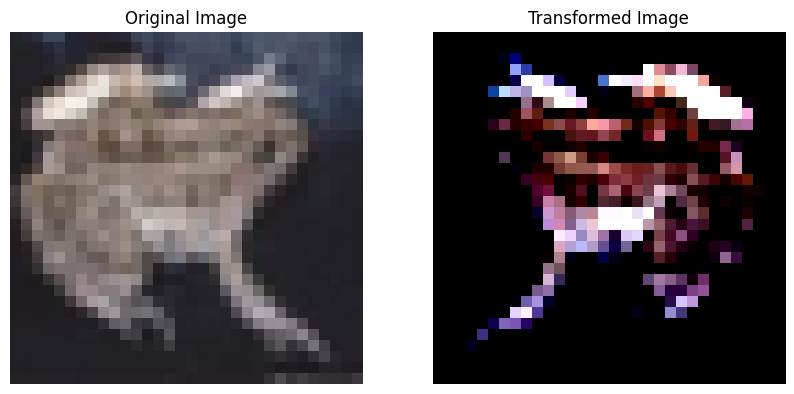

In [ ]:
# Function to display image before and after transformation
def show_image_before_and_after(X_data, transform, index=0):
    original_image = Image.fromarray(np.uint8(X_data[index]))  
    # Apply transformation to the image
    transformed_image = transform(np.array(original_image))  
    
    # Plot original and transformed images 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(transformed_image.permute(1, 2, 0).numpy())  
    axes[1].set_title("Transformed Image")
    axes[1].axis('off')

    plt.show()

show_image_before_and_after(X_train, train_transform, index=0)

In [ ]:
# Custom dataset class
class CIFAR10Dataset(Dataset):
    def __init__(self, X, Y, transform=None):
        """
        Args:
            X (numpy array): The input data (images).
            Y (numpy array): The labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        """Return the total number of samples."""
        return len(self.X)

    def __getitem__(self, idx):
        """Retrieve the sample at the given index."""
        image = self.X[idx].astype(np.uint8)
        label = self.Y[idx]
        
        # If a transform is provided, apply it
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [9]:
# Convert Y arrays to torch tensors
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Create Dataset objects
train_dataset = CIFAR10Dataset(X_train, Y_train_tensor, transform=train_transform)
val_dataset = CIFAR10Dataset(X_val, Y_val_tensor, transform=val_test_transform)
test_dataset = CIFAR10Dataset(X_test, Y_test_tensor, transform=val_test_transform)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

# iterating through a batch from the train loader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([128, 3, 32, 32]) torch.Size([128])


In [10]:
# Early Stopping 

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [11]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# RESNET 18

# Baseline

In [ ]:
# resnet 18 structure
models.resnet18(pretrained=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
# Defining the ResNet-18 baseline model
class ResNet18Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18Baseline, self).__init__()
        # Load a pre-trained ResNet-18 model since from scrach setting pre-trained = False
        self.model = models.resnet18(pretrained=False)
        # Modify the final fully connected layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18Baseline(num_classes=10).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)


In [34]:
# Training function with early stopping and tracking loss/accuracy
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Accumulate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation 
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Plot loss and accuracy curves
    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)



Epoch [1/50], Train Loss: 2.1196, Train Acc: 22.73%, Val Loss: 1.9324, Val Acc: 30.07%
Epoch [2/50], Train Loss: 1.8482, Train Acc: 33.12%, Val Loss: 1.7682, Val Acc: 35.58%
Epoch [3/50], Train Loss: 1.7162, Train Acc: 37.90%, Val Loss: 1.6631, Val Acc: 39.86%
Epoch [4/50], Train Loss: 1.6238, Train Acc: 40.71%, Val Loss: 1.5902, Val Acc: 41.44%
Epoch [5/50], Train Loss: 1.5596, Train Acc: 42.89%, Val Loss: 1.5305, Val Acc: 44.43%
Epoch [6/50], Train Loss: 1.5038, Train Acc: 45.33%, Val Loss: 1.4951, Val Acc: 45.81%
Epoch [7/50], Train Loss: 1.4607, Train Acc: 46.87%, Val Loss: 1.4588, Val Acc: 46.91%
Epoch [8/50], Train Loss: 1.4290, Train Acc: 48.14%, Val Loss: 1.4392, Val Acc: 47.58%
Epoch [9/50], Train Loss: 1.3898, Train Acc: 49.43%, Val Loss: 1.4095, Val Acc: 48.80%
Epoch [10/50], Train Loss: 1.3691, Train Acc: 50.31%, Val Loss: 1.3857, Val Acc: 49.84%
Epoch [11/50], Train Loss: 1.3414, Train Acc: 51.47%, Val Loss: 1.3669, Val Acc: 50.46%
Epoch [12/50], Train Loss: 1.3206, Train 

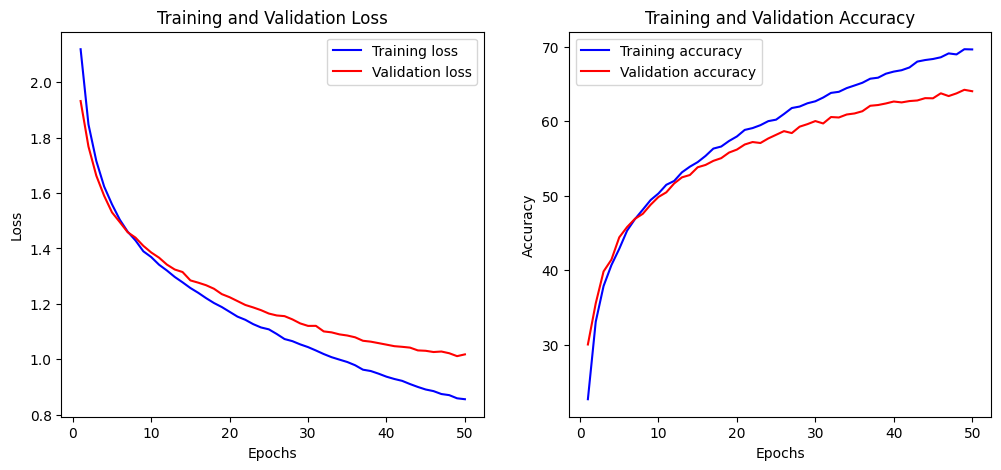

In [35]:
# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accumulate loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy


# Training the model with early stopping
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5)

# Save the trained model weights in path resnet18_baseline_cifar10
torch.save(model.state_dict(), 'resnet18_baseline_cifar10.pth')

In [36]:
# Test function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

# Testing the trained model in test dataset
test_model(model, test_loader)

Test Accuracy: 63.95%


# Hyperparameter tuning

In [ ]:
# Define the ResNet-18 model
class ResNet18Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18Baseline, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

### 1. learning rate = 1e-5, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2 
### l2 regularisation = 0.01
### Adam optimiser

In [ ]:
# Hyperparameter tuning function and L2 regularization
def hyperparameter_tuning(train_loader, val_loader, model_path, num_classes=10, num_epochs=10, patience=5, l2_lambda=0.01):
    # Hyperparameters grid
    learning_rates = [1e-5, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2 ]  

    # Best configuration tracking
    best_val_accuracy = 0.0
    best_config = None
    best_train_losses = []
    best_val_losses = []
    best_train_accuracies = []
    best_val_accuracies = []

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Iterate over all learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load weights, and move to device
        model = ResNet18Baseline(num_classes=num_classes).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)

        # Training with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, l2_lambda
        )

        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, l2_lambda)
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_train_accuracies = train_accuracies
            best_val_accuracies = val_accuracies
            
            # Save the best model weights
            torch.save(model.state_dict(), 'best_resnet18_l2_model.pth')
            print("Best model weights saved!")

    print(f"Best Configuration: LR={best_config[0]}, L2 Lambda={best_config[1]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


In [ ]:
# Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5, l2_lambda=0.01):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Add L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation step
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Validation function 
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Call the hyperparameter tuning function and provide the load baseline model path
model_path = 'resnet18_baseline_cifar10.pth'  
hyperparameter_tuning(train_loader, val_loader, model_path, num_classes=10, num_epochs=50, patience=3, l2_lambda=0.01)

In [28]:
# Function to test the best model using saved weights
def test_best_model(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = ResNet18Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_resnet18_l2_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best Model: {test_accuracy:.2f}%')

# After tuning, test the best saved model
test_best_model(test_loader, num_classes=10)


Training with LR=1e-05, L2 Regularization Lambda=0.01
Epoch [1/50], Train Loss: 6699.4153, Train Acc: 91.39%, Val Loss: 0.6823, Val Acc: 79.15%
Epoch [2/50], Train Loss: 6629.9120, Train Acc: 91.43%, Val Loss: 0.6783, Val Acc: 79.11%
Epoch [3/50], Train Loss: 6562.7037, Train Acc: 91.47%, Val Loss: 0.6728, Val Acc: 79.16%
Epoch [4/50], Train Loss: 6497.3956, Train Acc: 91.59%, Val Loss: 0.6707, Val Acc: 79.06%
Epoch [5/50], Train Loss: 6433.7619, Train Acc: 91.64%, Val Loss: 0.6653, Val Acc: 79.41%
Epoch [6/50], Train Loss: 6371.6200, Train Acc: 91.53%, Val Loss: 0.6667, Val Acc: 79.31%
Epoch [7/50], Train Loss: 6310.7837, Train Acc: 91.61%, Val Loss: 0.6589, Val Acc: 79.48%
Epoch [8/50], Train Loss: 6251.1259, Train Acc: 91.63%, Val Loss: 0.6582, Val Acc: 79.61%
Epoch [9/50], Train Loss: 6192.5228, Train Acc: 91.89%, Val Loss: 0.6512, Val Acc: 79.50%
Epoch [10/50], Train Loss: 6134.8947, Train Acc: 91.87%, Val Loss: 0.6490, Val Acc: 79.52%
Epoch [11/50], Train Loss: 6078.1655, Train A

### 2. learning rate = 1e-5, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2 
### l2 regularisation = 1e-6
### Adam optimiser

In [ ]:
# Hyperparameter tuning function with model saving and L2 regularization
def hyperparameter_tuning(train_loader, val_loader, model_path, num_classes=10, num_epochs=10, patience=5, l2_lambda=1e-6):
    # Hyperparameters grid
    learning_rates = [1e-5, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2]
    
    # Best configuration tracker
    best_val_accuracy = 0.0
    best_config = None
    best_train_losses = []
    best_val_losses = []
    best_train_accuracies = []
    best_val_accuracies = []

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Iterate over all learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load weights, and move to device
        model = ResNet18Baseline(num_classes=num_classes).to(device)
        
        # Load the saved model weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)  # Removed weight_decay here

        # Training with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, l2_lambda
        )

        # Update best model configuration if current is better
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, l2_lambda)
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_train_accuracies = train_accuracies
            best_val_accuracies = val_accuracies
            
            # Save the best model weights in path best_resnet18_l2_model
            torch.save(model.state_dict(), 'best_resnet18_l2_model.pth')
            print("Best model weights saved!")

    print(f"Best Configuration: LR={best_config[0]}, L2 Lambda={best_config[1]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

In [ ]:
# Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5, l2_lambda=1e-6):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Adding L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation 
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Call the hyperparameter tuning function and load the saved baseline model path
model_path = 'resnet18_baseline_cifar10.pth'
hyperparameter_tuning(train_loader, val_loader, model_path, num_classes=10, num_epochs=50, patience=3, l2_lambda=1e-6)

In [ ]:
# test the best model using saved weights
def test_best_model(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = ResNet18Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_resnet18_l2_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best Model: {test_accuracy:.2f}%')

test_best_model(test_loader, num_classes=10)


Training with LR=1e-05, L2 Regularization Lambda=1e-06
Epoch [1/50], Train Loss: 0.9191, Train Acc: 91.57%, Val Loss: 0.6762, Val Acc: 79.38%
Epoch [2/50], Train Loss: 0.8964, Train Acc: 92.21%, Val Loss: 0.6674, Val Acc: 79.75%
Epoch [3/50], Train Loss: 0.8902, Train Acc: 92.45%, Val Loss: 0.6605, Val Acc: 79.99%
Epoch [4/50], Train Loss: 0.8874, Train Acc: 92.31%, Val Loss: 0.6536, Val Acc: 80.14%
Epoch [5/50], Train Loss: 0.8765, Train Acc: 92.66%, Val Loss: 0.6455, Val Acc: 80.26%
Epoch [6/50], Train Loss: 0.8720, Train Acc: 92.84%, Val Loss: 0.6414, Val Acc: 80.39%
Epoch [7/50], Train Loss: 0.8659, Train Acc: 93.16%, Val Loss: 0.6394, Val Acc: 80.46%
Epoch [8/50], Train Loss: 0.8624, Train Acc: 93.04%, Val Loss: 0.6375, Val Acc: 80.62%
Epoch [9/50], Train Loss: 0.8605, Train Acc: 93.05%, Val Loss: 0.6366, Val Acc: 80.58%
Epoch [10/50], Train Loss: 0.8548, Train Acc: 93.41%, Val Loss: 0.6375, Val Acc: 80.54%
Epoch [11/50], Train Loss: 0.8530, Train Acc: 93.41%, Val Loss: 0.6360, Va

### 3. learning_rates = 1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2
### l2 regularisation = 1e-6
### momentum = 0.9
### SGD

In [ ]:
# Hyperparameter tuning function with model saving and L2 regularization
def hyperparameter_tuning(train_loader, val_loader, model_path, num_classes=10, num_epochs=10, patience=5, l2_lambda=1e-6):
    # Hyperparameters grid
    learning_rates = [1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2]
    momentum = 0.8  # Set momentum for SGD

    # Best configuration tracker
    best_val_accuracy = 0.0
    best_config = None
    best_train_losses = []
    best_val_losses = []
    best_train_accuracies = []
    best_val_accuracies = []

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Iterate over all learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, Momentum={momentum}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load weights, and move to device
        model = ResNet18Baseline(num_classes=num_classes).to(device)
        
        # Load the saved model weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=l2_lambda)

        # Training with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, l2_lambda
        )

        # Update best model configuration if current is better
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, l2_lambda)
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_train_accuracies = train_accuracies
            best_val_accuracies = val_accuracies
            
            # Save the best model weights
            torch.save(model.state_dict(), 'best_resnet18_l2_model.pth')
            print("Best model weights saved!")

    print(f"Best Configuration: LR={best_config[0]}, L2 Lambda={best_config[1]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

In [ ]:
# Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5, l2_lambda=1e-6):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Add L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation step
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Validation function (modified to accept device)
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Call the hyperparameter tuning function and provide the saved model path
model_path = 'resnet18_baseline_cifar10.pth'  
hyperparameter_tuning(train_loader, val_loader, model_path, num_classes=10, num_epochs=50, patience=3, l2_lambda= 1e-6)


In [ ]:

# Function to test the best model using saved weights
def test_best_model(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = ResNet18Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_resnet18_l2_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best Model: {test_accuracy:.2f}%')

# After tuning, test the best saved model
test_best_model(test_loader, num_classes=10)


Training with LR=0.001, Momentum=0.8, L2 Regularization Lambda=1e-06
Epoch [1/50], Train Loss: 0.9146, Train Acc: 91.63%, Val Loss: 0.6644, Val Acc: 79.65%
Epoch [2/50], Train Loss: 0.9004, Train Acc: 92.02%, Val Loss: 0.6603, Val Acc: 79.86%
Epoch [3/50], Train Loss: 0.8927, Train Acc: 92.53%, Val Loss: 0.6572, Val Acc: 80.15%
Epoch [4/50], Train Loss: 0.8849, Train Acc: 92.82%, Val Loss: 0.6519, Val Acc: 80.17%
Epoch [5/50], Train Loss: 0.8822, Train Acc: 92.88%, Val Loss: 0.6502, Val Acc: 80.31%
Epoch [6/50], Train Loss: 0.8792, Train Acc: 93.00%, Val Loss: 0.6524, Val Acc: 80.43%
Epoch [7/50], Train Loss: 0.8782, Train Acc: 93.03%, Val Loss: 0.6575, Val Acc: 80.31%
Epoch [8/50], Train Loss: 0.8777, Train Acc: 92.97%, Val Loss: 0.6494, Val Acc: 80.51%
Epoch [9/50], Train Loss: 0.8778, Train Acc: 92.95%, Val Loss: 0.6567, Val Acc: 80.52%
Epoch [10/50], Train Loss: 0.8760, Train Acc: 93.08%, Val Loss: 0.6473, Val Acc: 80.59%
Epoch [11/50], Train Loss: 0.8726, Train Acc: 93.15%, Val Lo

# MOBILENET

# Baseline

In [ ]:
# MobileNetV2 structure
models.mobilenet_v2(pretrained=False)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [17]:
# Defining the MobileNetV2 baseline model
class MobileNetV2Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetV2Baseline, self).__init__()
        # Load a pre-trained MobileNetV2 model since it is trained from scrach pretrained = ffalse
        self.model = models.mobilenet_v2(pretrained=False)
        # Modifying the final classifier layer to match the number of classes
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [18]:
# Function to train and save the MobileNetV2 baseline model with early stopping
def train_mobilenetv2_baseline(train_loader, val_loader, num_classes=10, num_epochs=50, patience=5):
    # Initialize the model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MobileNetV2Baseline(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Track best model based on validation accuracy
    best_val_accuracy = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Save the model if the validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'mobilenetv2_baseline.pth')

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Plot loss and accuracy curves
    plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)


In [19]:
# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

Epoch [1/50], Train Loss: 2.3321, Train Acc: 11.93%, Val Loss: 2.2952, Val Acc: 13.03%
Epoch [2/50], Train Loss: 2.2793, Train Acc: 14.15%, Val Loss: 2.2319, Val Acc: 16.14%
Epoch [3/50], Train Loss: 2.1947, Train Acc: 17.48%, Val Loss: 2.1359, Val Acc: 19.28%
Epoch [4/50], Train Loss: 2.0950, Train Acc: 21.31%, Val Loss: 2.0304, Val Acc: 22.96%
Epoch [5/50], Train Loss: 2.0230, Train Acc: 23.28%, Val Loss: 1.9841, Val Acc: 23.63%
Epoch [6/50], Train Loss: 1.9651, Train Acc: 25.03%, Val Loss: 1.9169, Val Acc: 27.26%
Epoch [7/50], Train Loss: 1.9030, Train Acc: 27.36%, Val Loss: 1.8546, Val Acc: 28.88%
Epoch [8/50], Train Loss: 1.8572, Train Acc: 29.16%, Val Loss: 1.8090, Val Acc: 31.30%
Epoch [9/50], Train Loss: 1.8194, Train Acc: 30.80%, Val Loss: 1.7713, Val Acc: 32.36%
Epoch [10/50], Train Loss: 1.7816, Train Acc: 32.29%, Val Loss: 1.7509, Val Acc: 33.49%
Epoch [11/50], Train Loss: 1.7425, Train Acc: 33.88%, Val Loss: 1.7209, Val Acc: 34.76%
Epoch [12/50], Train Loss: 1.7157, Train 

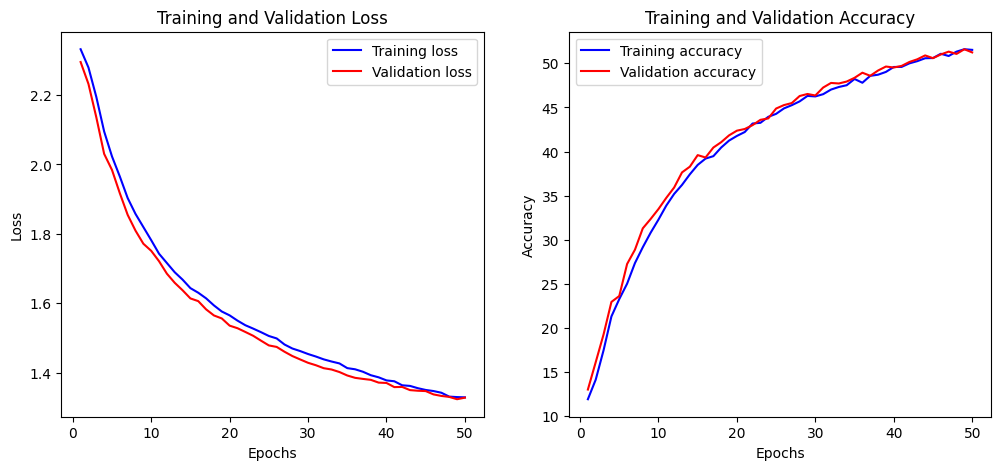

Test Accuracy of the MobileNetV2 Baseline Model: 51.41%


In [20]:
# Function to test the model with the saved best weights
def test_mobilenetv2_baseline(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = MobileNetV2Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('mobilenetv2_baseline.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the MobileNetV2 Baseline Model: {test_accuracy:.2f}%')

# train, save, and test the baseline model
train_mobilenetv2_baseline(train_loader, val_loader, num_classes=10, num_epochs=50, patience=5)
test_mobilenetv2_baseline(test_loader, num_classes=10)


# Hyperparameter tuning



In [21]:
# Define the MobileNetV2 baseline model
class MobileNetV2Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetV2Baseline, self).__init__()
        # Load a pre-trained MobileNetV2 model
        self.model = models.mobilenet_v2(pretrained=False)
        # Modify the final classifier layer to match the number of classes
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)
    

#### 1. learning_rates = 1e-5,0.1e-6, 0.01, 0.1, 0.001, 0.005
#### L2 regularisation = 0.01
#### optimiser = Adam

In [ ]:
  # Hyperparameter tuning function
def hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=0.01):
    # learning rates 
    learning_rates = [1e-5,0.1e-6, 0.01, 0.1, 0.001, 0.005]

    # Track the best configuration
    best_val_accuracy = 0.0
    best_config = None

    # Iterate over learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load baseline weights, optimizer, and loss function
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = MobileNetV2Baseline(num_classes=num_classes).to(device)
        
        # Load the baseline weights
        model.load_state_dict(torch.load(baseline_path, map_location=device))

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)  

        # Train the model with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, l2_lambda
        )

        # Save the best configuration
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, l2_lambda)

            # Save best model weights
            torch.save(model.state_dict(), 'best_mobilenetv2_hyperparam_model.pth')
            print("Best MobileNetV2 model weights saved after hyperparameter tuning!")

        del model
        torch.cuda.empty_cache()

    print(f"Best Configuration: LR={best_config[0]}, L2 Lambda={best_config[1]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

In [ ]:
# Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5, l2_lambda=0.01):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Adding L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [41]:

# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [42]:
# Function to test the model with the saved best weights
def test_mobilenetv2_baseline(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = MobileNetV2Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_mobilenetv2_hyperparam_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best MobileNetV2 Model after Hyperparameter Tuning: {test_accuracy:.2f}%')

# Path to the baseline model weights
baseline_path = 'mobilenetv2_baseline.pth'  
hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=0.01)

# Test the best-tuned model
test_mobilenetv2_baseline(test_loader, num_classes=10)


Training with LR=1e-05, L2 Regularization Lambda=0.01
Epoch [1/50], Train Loss: 414.3255, Train Acc: 82.52%, Val Loss: 0.6638, Val Acc: 77.51%
Epoch [2/50], Train Loss: 403.0598, Train Acc: 82.73%, Val Loss: 0.6523, Val Acc: 77.80%
Epoch [3/50], Train Loss: 392.3023, Train Acc: 82.84%, Val Loss: 0.6472, Val Acc: 78.18%
Epoch [4/50], Train Loss: 382.0004, Train Acc: 83.30%, Val Loss: 0.6400, Val Acc: 78.36%
Epoch [5/50], Train Loss: 372.1281, Train Acc: 83.59%, Val Loss: 0.6374, Val Acc: 78.37%
Epoch [6/50], Train Loss: 362.6474, Train Acc: 83.50%, Val Loss: 0.6347, Val Acc: 78.56%
Epoch [7/50], Train Loss: 353.5262, Train Acc: 83.97%, Val Loss: 0.6324, Val Acc: 78.46%
Epoch [8/50], Train Loss: 344.7499, Train Acc: 84.12%, Val Loss: 0.6340, Val Acc: 78.45%
Epoch [9/50], Train Loss: 336.2966, Train Acc: 83.89%, Val Loss: 0.6342, Val Acc: 78.51%
Epoch [10/50], Train Loss: 328.1465, Train Acc: 84.29%, Val Loss: 0.6338, Val Acc: 78.67%
Epoch [11/50], Train Loss: 320.2878, Train Acc: 84.08%,

#### 2. learning_rates = 1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2
#### L2 regularisation = 1e-6
#### optimiser = Adam

In [43]:
  # Hyperparameter tuning function
def hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=1e-06):
    # Define learning rates 
    learning_rates = [1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2]

    # Track the best configuration
    best_val_accuracy = 0.0
    best_config = None

    # Iterate over learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load baseline weights, optimizer, and loss function
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = MobileNetV2Baseline(num_classes=num_classes).to(device)
        
        # Load the baseline weights
        model.load_state_dict(torch.load(baseline_path, map_location=device))

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)  # Removed weight_decay here

        # Training the model with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, l2_lambda
        )

        # Saving the best configuration
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, l2_lambda)

            # Save best model weights
            torch.save(model.state_dict(), 'best_mobilenetv2_hyperparam_model.pth')
            print("Best MobileNetV2 model weights saved after hyperparameter tuning!")

        del model
        torch.cuda.empty_cache()

    print(f"Best Configuration: LR={best_config[0]}, L2 Lambda={best_config[1]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

In [44]:
# Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5, l2_lambda=1e-06):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Adding L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [45]:
# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy


In [ ]:
#  test the model with the saved best weights
def test_mobilenetv2_baseline(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = MobileNetV2Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_mobilenetv2_hyperparam_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best MobileNetV2 Model after Hyperparameter Tuning: {test_accuracy:.2f}%')

# baseline model weights
baseline_path = 'mobilenetv2_baseline.pth'  
hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=1e-06)

# Test the best-tuned model
test_mobilenetv2_baseline(test_loader, num_classes=10)


Training with LR=0.001, L2 Regularization Lambda=1e-06
Epoch [1/50], Train Loss: 0.6067, Train Acc: 80.38%, Val Loss: 0.7004, Val Acc: 76.11%
Epoch [2/50], Train Loss: 0.5821, Train Acc: 81.06%, Val Loss: 0.6983, Val Acc: 76.39%
Epoch [3/50], Train Loss: 0.5740, Train Acc: 81.29%, Val Loss: 0.6858, Val Acc: 76.96%
Epoch [4/50], Train Loss: 0.5558, Train Acc: 81.86%, Val Loss: 0.6970, Val Acc: 76.75%
Epoch [5/50], Train Loss: 0.5405, Train Acc: 82.27%, Val Loss: 0.6831, Val Acc: 76.92%
Epoch [6/50], Train Loss: 0.5212, Train Acc: 83.04%, Val Loss: 0.6803, Val Acc: 77.38%
Epoch [7/50], Train Loss: 0.5097, Train Acc: 83.26%, Val Loss: 0.6919, Val Acc: 77.15%
Epoch [8/50], Train Loss: 0.5093, Train Acc: 83.52%, Val Loss: 0.6690, Val Acc: 77.89%
Epoch [9/50], Train Loss: 0.5019, Train Acc: 83.77%, Val Loss: 0.6844, Val Acc: 77.38%
Epoch [10/50], Train Loss: 0.4812, Train Acc: 84.39%, Val Loss: 0.6598, Val Acc: 77.94%
Epoch [11/50], Train Loss: 0.4691, Train Acc: 84.87%, Val Loss: 0.6594, Va

### 3. learning_rates = 1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2
### l2 regularisation = 1e-6
### momentum = 0.9
### SGD

In [ ]:
# Hyperparameter tuning function with model saving and L2 regularization
def hyperparameter_tuning(train_loader, val_loader, model_path, num_classes=10, num_epochs=10, patience=5, l2_lambda=1e-6):
    # Hyperparameters grid
    learning_rates = [1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2]
    momentum = 0.8  # momentum for SGD

    # Best configuration tracker
    best_val_accuracy = 0.0
    best_config = None
    best_train_losses = []
    best_val_losses = []
    best_train_accuracies = []
    best_val_accuracies = []

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Iterate over all learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, Momentum={momentum}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load weights, and move to device
        model = MobileNetV2Baseline(num_classes=num_classes).to(device)
        
        # Load the saved model weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=l2_lambda)

        # Training with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, l2_lambda
        )

        # save best model configuration if current is better
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, l2_lambda)
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_train_accuracies = train_accuracies
            best_val_accuracies = val_accuracies
            
            # Save the best model weights
            torch.save(model.state_dict(), 'best_mobilenetv2_l2_model.pth')
            print("Best model weights saved!")

    print(f"Best Configuration: LR={best_config[0]}, L2 Lambda={best_config[1]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

In [ ]:
# Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5, l2_lambda=1e-6):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation step
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Validation function 
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Call the hyperparameter tuning function and the saved model path
model_path = 'mobilenetv2_baseline.pth'  
hyperparameter_tuning(train_loader, val_loader, model_path, num_classes=10, num_epochs=50, patience=3, l2_lambda=1e-6)

# Function to test the best model using saved weights
def test_best_model(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = MobileNetV2Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_mobilenetv2_l2_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best Model: {test_accuracy:.2f}%')

# After tuning, test the best saved model
test_best_model(test_loader, num_classes=10)


Training with LR=0.001, Momentum=0.8, L2 Regularization Lambda=1e-06
Epoch [1/50], Train Loss: 0.5313, Train Acc: 83.04%, Val Loss: 0.6516, Val Acc: 78.03%
Epoch [2/50], Train Loss: 0.5074, Train Acc: 84.12%, Val Loss: 0.6374, Val Acc: 78.42%
Epoch [3/50], Train Loss: 0.4987, Train Acc: 84.03%, Val Loss: 0.6320, Val Acc: 78.41%
Epoch [4/50], Train Loss: 0.4886, Train Acc: 84.35%, Val Loss: 0.6355, Val Acc: 78.59%
Epoch [5/50], Train Loss: 0.4882, Train Acc: 84.44%, Val Loss: 0.6273, Val Acc: 78.88%
Epoch [6/50], Train Loss: 0.4715, Train Acc: 84.97%, Val Loss: 0.6446, Val Acc: 78.06%
Epoch [7/50], Train Loss: 0.4719, Train Acc: 84.94%, Val Loss: 0.6336, Val Acc: 78.47%
Epoch [8/50], Train Loss: 0.4728, Train Acc: 84.81%, Val Loss: 0.6226, Val Acc: 78.62%
Epoch [9/50], Train Loss: 0.4692, Train Acc: 85.22%, Val Loss: 0.6320, Val Acc: 78.77%
Epoch [10/50], Train Loss: 0.4592, Train Acc: 85.31%, Val Loss: 0.6257, Val Acc: 78.85%
Epoch [11/50], Train Loss: 0.4601, Train Acc: 85.40%, Val Lo

# SHUFFLENET

# Baseline

In [ ]:
# ShuffleNetv2_x1_0 structure
models.shufflenet_v2_x1_0(pretrained=False)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
# Define the ShuffleNetV2 baseline model
class ShuffleNetV2Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(ShuffleNetV2Baseline, self).__init__()
        # Load a ShuffleNetV2 model from scracth predefined = False
        self.model = models.shufflenet_v2_x1_0(pretrained=False)
        # Modify the final classifier layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:

# Function to train and save the baseline ShuffleNetV2 model
def train_shufflenet_baseline(train_loader, val_loader, num_classes=10, num_epochs=50, patience=5):
    # Initialize the model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ShuffleNetV2Baseline(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Track best model based on validation accuracy
    best_val_accuracy = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Save the model if the validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'shufflenetv2_baseline.pth')
            #print("Best ShuffleNetV2 model weights saved!")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

In [14]:
# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

Epoch [1/50], Train Loss: 2.3298, Train Acc: 11.43%, Val Loss: 2.3044, Val Acc: 13.01%
Epoch [2/50], Train Loss: 2.2880, Train Acc: 13.50%, Val Loss: 2.2717, Val Acc: 14.82%
Epoch [3/50], Train Loss: 2.2426, Train Acc: 15.97%, Val Loss: 2.2216, Val Acc: 17.08%
Epoch [4/50], Train Loss: 2.1893, Train Acc: 18.21%, Val Loss: 2.1712, Val Acc: 18.86%
Epoch [5/50], Train Loss: 2.1300, Train Acc: 20.11%, Val Loss: 2.0969, Val Acc: 20.51%
Epoch [6/50], Train Loss: 2.0748, Train Acc: 22.02%, Val Loss: 2.0462, Val Acc: 23.22%
Epoch [7/50], Train Loss: 2.0188, Train Acc: 23.83%, Val Loss: 1.9900, Val Acc: 24.77%
Epoch [8/50], Train Loss: 1.9732, Train Acc: 25.54%, Val Loss: 1.9491, Val Acc: 26.76%
Epoch [9/50], Train Loss: 1.9356, Train Acc: 26.84%, Val Loss: 1.9066, Val Acc: 28.03%
Epoch [10/50], Train Loss: 1.8980, Train Acc: 28.65%, Val Loss: 1.8788, Val Acc: 29.64%
Epoch [11/50], Train Loss: 1.8680, Train Acc: 29.62%, Val Loss: 1.8504, Val Acc: 30.32%
Epoch [12/50], Train Loss: 1.8378, Train 

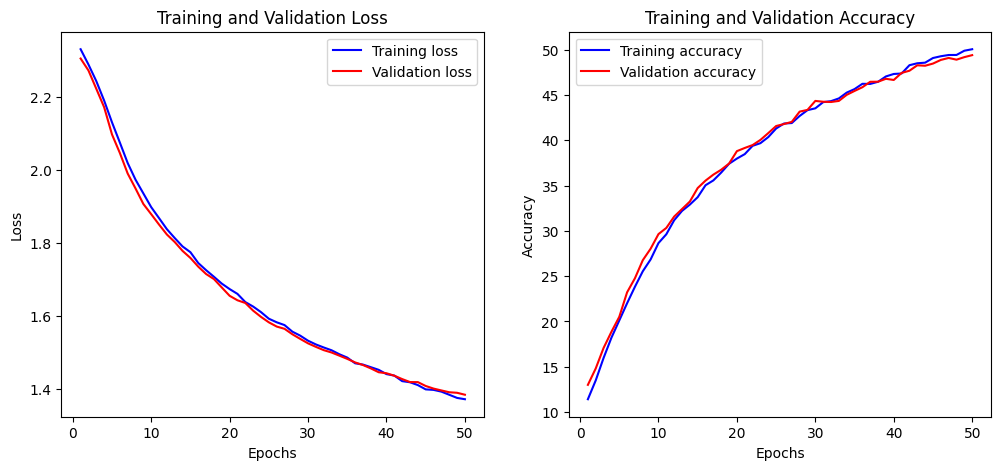

Test Accuracy of the ShuffleNetV2 Baseline Model: 50.32%


In [ ]:
# Function to test the model with the saved best weights
def test_shufflenet_baseline(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = ShuffleNetV2Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('shufflenetv2_baseline.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the ShuffleNetV2 Baseline Model: {test_accuracy:.2f}%')

# save, and test the baseline model
train_shufflenet_baseline(train_loader, val_loader, num_classes=10, num_epochs=50, patience=5)
test_shufflenet_baseline(test_loader, num_classes=10)

# Hyperparameter Tuning

#### 1. learning_rates = 1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2
#### l2 Regularisation = 0.005
#### momentum = 0.9 
#### Optimiser = SGD

In [ ]:
# Hyperparameter tuning function with fixed momentum and L2 regularization
def hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=0.005):
    # Hyperparameter grid
    learning_rates = [1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2]
    momentum = 0.9  # momentum value since sgd is used

    # Track the best configuration
    best_val_accuracy = 0.0
    best_config = None
    best_train_losses, best_val_losses = [], []
    best_train_accuracies, best_val_accuracies = [], []

    # Iterate over learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, Momentum={momentum}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load baseline weights, optimizer, and loss function
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ShuffleNetV2Baseline(num_classes=num_classes).to(device)
        
        # Load the baseline weights
        model.load_state_dict(torch.load(baseline_path, map_location=device))

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=l2_lambda)

        # Train the model with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience
        )

        # Save the best configuration
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, momentum, l2_lambda)
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_train_accuracies = train_accuracies
            best_val_accuracies = val_accuracies

            # Save best model weights
            torch.save(model.state_dict(), 'best_shufflenetv2_hyperparam_model.pth')
            print("Best ShuffleNetV2 model weights saved after hyperparameter tuning!")

    print(f"Best Configuration: LR={best_config[0]}, Momentum={best_config[1]}, L2 Lambda={best_config[2]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


In [ ]:
# Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [15]:
# Test the best-tuned model
def test_shufflenet_baseline(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = ShuffleNetV2Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_shufflenetv2_hyperparam_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best Model: {test_accuracy:.2f}%')


baseline_path = 'shufflenetv2_baseline.pth' 
hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=0.005)
test_shufflenet_baseline(test_loader, num_classes=10)


Training with LR=0.001, Momentum=0.9, L2 Regularization Lambda=0.005
Epoch [1/50], Train Loss: 0.4886, Train Acc: 82.67%, Val Loss: 0.7321, Val Acc: 75.53%
Epoch [2/50], Train Loss: 0.4607, Train Acc: 83.80%, Val Loss: 0.7210, Val Acc: 75.69%
Epoch [3/50], Train Loss: 0.4487, Train Acc: 84.20%, Val Loss: 0.7197, Val Acc: 75.72%
Epoch [4/50], Train Loss: 0.4441, Train Acc: 84.48%, Val Loss: 0.7079, Val Acc: 75.85%
Epoch [5/50], Train Loss: 0.4346, Train Acc: 85.09%, Val Loss: 0.7162, Val Acc: 75.64%
Epoch [6/50], Train Loss: 0.4279, Train Acc: 85.17%, Val Loss: 0.7196, Val Acc: 75.83%
Epoch [7/50], Train Loss: 0.4218, Train Acc: 85.42%, Val Loss: 0.7180, Val Acc: 75.40%
Epoch [8/50], Train Loss: 0.4142, Train Acc: 85.65%, Val Loss: 0.7096, Val Acc: 76.11%
Epoch [9/50], Train Loss: 0.4096, Train Acc: 85.90%, Val Loss: 0.7129, Val Acc: 75.76%
Early stopping triggered
Best ShuffleNetV2 model weights saved after hyperparameter tuning!
Training with LR=3e-05, Momentum=0.9, L2 Regularization 

#### 2. learning_rates = 1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2
#### l2 Regularisation = 0.01
#### Optimiser = Adam

In [ ]:
# Hyperparameter tuning function with L2 regularization
def hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=0.01):
    # Define learning rates to tune
    learning_rates = [1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2]

    # Track the best configuration
    best_val_accuracy = 0.0
    best_config = None
    best_train_losses, best_val_losses = [], []
    best_train_accuracies, best_val_accuracies = [], []

    # Iterate over learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load baseline weights, optimizer, and loss function
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ShuffleNetV2Baseline(num_classes=num_classes).to(device)
        
        # Load the baseline weights
        model.load_state_dict(torch.load(baseline_path, map_location=device))

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr) 

        # Train the model with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, l2_lambda
        )

        # Save the best configuration
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, l2_lambda)
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_train_accuracies = train_accuracies
            best_val_accuracies = val_accuracies

            # Save best model weights
            torch.save(model.state_dict(), 'best_shufflenetv2_hyperparam_model.pth')
            print("Best ShuffleNetV2 model weights saved after hyperparameter tuning!")

    print(f"Best Configuration: LR={best_config[0]}, L2 Lambda={best_config[1]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


In [ ]:
# Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5, l2_lambda=0.01):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [ ]:

# Fu test the model with the saved best weights
def test_shufflenet_baseline(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = ShuffleNetV2Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_shufflenetv2_hyperparam_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best ShuffleNetV2 Model after Hyperparameter Tuning: {test_accuracy:.2f}%')


baseline_path = 'shufflenetv2_baseline.pth' 
hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=0.01)
test_shufflenet_baseline(test_loader, num_classes=10)


Training with LR=1e-05, L2 Regularization Lambda=0.01
Epoch [1/50], Train Loss: 154.0156, Train Acc: 82.32%, Val Loss: 0.7493, Val Acc: 75.19%
Epoch [2/50], Train Loss: 149.4957, Train Acc: 82.85%, Val Loss: 0.7404, Val Acc: 75.23%
Epoch [3/50], Train Loss: 145.2358, Train Acc: 83.22%, Val Loss: 0.7363, Val Acc: 75.25%
Epoch [4/50], Train Loss: 141.2196, Train Acc: 83.15%, Val Loss: 0.7315, Val Acc: 75.36%
Epoch [5/50], Train Loss: 137.4058, Train Acc: 83.36%, Val Loss: 0.7311, Val Acc: 75.33%
Epoch [6/50], Train Loss: 133.7818, Train Acc: 83.78%, Val Loss: 0.7330, Val Acc: 75.54%
Epoch [7/50], Train Loss: 130.3360, Train Acc: 83.83%, Val Loss: 0.7258, Val Acc: 75.48%
Epoch [8/50], Train Loss: 127.0542, Train Acc: 84.02%, Val Loss: 0.7266, Val Acc: 75.53%
Epoch [9/50], Train Loss: 123.9385, Train Acc: 84.11%, Val Loss: 0.7223, Val Acc: 75.38%
Epoch [10/50], Train Loss: 120.9814, Train Acc: 84.14%, Val Loss: 0.7209, Val Acc: 75.51%
Epoch [11/50], Train Loss: 118.1512, Train Acc: 84.22%,

#### 3. learning_rates = 1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2
#### l2 Regularisation = 1e-7
#### Optimiser = Adam


In [ ]:
# Hyperparameter tuning function with L2 regularization
def hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=1e-7):
    # hyperparameter grid
    learning_rates = [1e-3, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3, 1e-2]

    # Track the best configuration
    best_val_accuracy = 0.0
    best_config = None
    best_train_losses, best_val_losses = [], []
    best_train_accuracies, best_val_accuracies = [], []

    # Iterate over learning rates
    for lr in learning_rates:
        print(f"Training with LR={lr}, L2 Regularization Lambda={l2_lambda}")

        # Initialize model, load baseline weights, optimizer, and loss function
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ShuffleNetV2Baseline(num_classes=num_classes).to(device)
        
        # Load the baseline weights
        model.load_state_dict(torch.load(baseline_path, map_location=device))

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr) 

        # Train the model with early stopping
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, l2_lambda
        )

        # Save the best configuration
        if max(val_accuracies) > best_val_accuracy:
            best_val_accuracy = max(val_accuracies)
            best_config = (lr, l2_lambda)
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_train_accuracies = train_accuracies
            best_val_accuracies = val_accuracies

            # Save best model weights
            torch.save(model.state_dict(), 'best_shufflenetv2_hyperparam_model.pth')
            print("Best ShuffleNetV2 model weights saved after hyperparameter tuning!")

    print(f"Best Configuration: LR={best_config[0]}, L2 Lambda={best_config[1]}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


In [ ]:
    # Training function with L2 regularization
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5, l2_lambda=1e-7):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Add L2 regularization
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy


In [ ]:

#  test the model with the saved best weights
def test_shufflenet_baseline(test_loader, num_classes=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize and load the best model
    model = ShuffleNetV2Baseline(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load('best_shufflenetv2_hyperparam_model.pth', map_location=device))
    
    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy of the Best ShuffleNetV2 Model after Hyperparameter Tuning: {test_accuracy:.2f}%')

baseline_path = 'shufflenetv2_baseline.pth'  
hyperparameter_tuning(train_loader, val_loader, baseline_path, num_classes=10, num_epochs=50, patience=5, l2_lambda=1e-7)
test_shufflenet_baseline(test_loader, num_classes=10)


Training with LR=0.001, L2 Regularization Lambda=1e-07
Epoch [1/50], Train Loss: 0.5526, Train Acc: 80.45%, Val Loss: 0.7771, Val Acc: 73.90%
Epoch [2/50], Train Loss: 0.5369, Train Acc: 81.20%, Val Loss: 0.9337, Val Acc: 70.27%
Epoch [3/50], Train Loss: 0.5863, Train Acc: 79.28%, Val Loss: 0.7612, Val Acc: 74.24%
Epoch [4/50], Train Loss: 0.5197, Train Acc: 81.51%, Val Loss: 0.7877, Val Acc: 73.85%
Epoch [5/50], Train Loss: 0.4945, Train Acc: 82.51%, Val Loss: 0.7733, Val Acc: 74.20%
Epoch [6/50], Train Loss: 0.4974, Train Acc: 82.34%, Val Loss: 0.7855, Val Acc: 74.24%
Epoch [7/50], Train Loss: 0.4757, Train Acc: 83.22%, Val Loss: 0.8091, Val Acc: 73.98%
Epoch [8/50], Train Loss: 0.4643, Train Acc: 83.53%, Val Loss: 0.7700, Val Acc: 75.17%
Early stopping triggered
Best ShuffleNetV2 model weights saved after hyperparameter tuning!
Training with LR=3e-05, L2 Regularization Lambda=1e-07
Epoch [1/50], Train Loss: 0.4771, Train Acc: 83.16%, Val Loss: 0.7438, Val Acc: 75.26%
Epoch [2/50], T

# Reference

[1] “Image Classification with PyTorch,” Pluralsight.com, 2020. https://www.pluralsight.com/resources/blog/guides/image-classification-with-pytorch (accessed Nov. 02, 2024).

[2] benlambda, “PyTorch Transfer Learning with MobileNetv2 CNN,” Kaggle.com, Mar. 02, 2023. https://www.kaggle.com/code/benlambda/pytorch-transfer-learning-with-mobilenetv2-cnn (accessed Nov. 02, 2024).

[3] “Transfer Learning with ResNet in PyTorch,” www.pluralsight.com. https://www.pluralsight.com/resources/blog/guides/introduction-to-resnet

[4] S. Sharma, “Fine Tuning Pretrained Model MobileNet_V2 in Pytorch,” Stack Overflow, Jul. 31, 2019. https://stackoverflow.com/questions/57285224/fine-tuning-pretrained-model-mobilenet-v2-in-pytorch

‌‌[5] “ShuffleNet V2 — Torchvision main documentation,” Pytorch.org, 2023. https://pytorch.org/vision/main/models/shufflenetv2.html (accessed Nov. 02, 2024).

[6] A. Krizhevsky, “CIFAR-10 and CIFAR-100 datasets,” Toronto.edu, 2009. https://www.cs.toronto.edu/~kriz/cifar.html
‌
‌
‌